# Data Preprocessing and Training Data Extraction

In [1]:
import sys

import csv
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [2]:
item_ids = set()
with open('../Dataset/item_metadata.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        item_ids.add(int(line[0]))
        
with open('../Dataset/train.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        if line[4] in ['clickout item', 'interaction item deals', 'interaction item image', 'interaction item info',  'interaction item rating',  'search for item'] and line[5].isdigit():
            item_ids.add(int(line[5]))
        if line[10] != '':
            item_ids.update(set(list(map(int, line[10].split('|')))))
            
with open('../Dataset/test.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        if line[4] in ['clickout item', 'interaction item deals', 'interaction item image', 'interaction item info',  'interaction item rating',  'search for item']  and line[5].isdigit():
            item_ids.add(int(line[5]))
        if line[10] != '':
            item_ids.update(set(list(map(int, line[10].split('|')))))

In [3]:
property_to_index = {}
with open('../Dataset/item_metadata.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    index = 0
    for line in tqdm(reader):
        for prop in line[1].split('|'):
            if prop not in property_to_index:
                property_to_index[prop] = index
                index += 1

In [4]:
item_to_property = {}

for item in item_ids:
    item_to_property[item] = np.zeros(157)

with open('../Dataset/item_metadata.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        for prop in line[1].split('|'):
            item_to_property[int(line[0])][property_to_index[prop]] = 1

In [5]:
user = set()
action_type = set()
platform = set()
city = set()
device = set()
current_filters = set()

In [6]:
with open('../Dataset/train.csv') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        user.add(line[0])
        action_type.add(line[4])
        platform.add(line[6])
        city.add(line[7])
        device.add(line[8])
        if line[9]:
            for filter in line[9].split('|'):
                current_filters.add(filter)
            
with open('../Dataset/test.csv') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        user.add(line[0])
        action_type.add(line[4])
        platform.add(line[6])
        city.add(line[7])
        device.add(line[8])
        if line[9]:
            for filter in line[9].split('|'):
                current_filters.add(filter)

In [7]:
user = sorted(list(user))
action_type = sorted(list(action_type))
platform = sorted(list(platform))
city = sorted(list(city))
device = sorted(list(device))
current_filters = sorted(list(current_filters))

In [8]:
user_to_ind = {user[i]:i for i in range(len(user))}
action_to_ind = {action_type[i]:i for i in range(len(action_type))}
platform_to_ind = {platform[i]:i for i in range(len(platform))}
city_to_ind = {city[i]:i for i in range(len(city))}
device_to_ind = {device[i]:i for i in range(len(device))}
current_filters_to_ind = {current_filters[i]:i for i in range(len(current_filters))}

In [9]:
reference = [set() for _ in range(10)]
with open('../Dataset/train.csv') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        reference[action_to_ind[line[4]]].add(line[5])

with open('../Dataset/test.csv') as f:
    reader = csv.reader(f)
    next(reader)
    
    for line in tqdm(reader):
        reference[action_to_ind[line[4]]].add(line[5])

In [10]:
# reference_to_ind[i]: dictionary object that maps reference string of action_type[i] to integer index

reference_to_ind = [{} for _ in range(10)]
for i in range(10):
    reference_i = list(reference[i])
    
    if i in [1, 3, 4, 5, 6, 8]:    # for items, non-item-index references are mapped to zero. item-indexes are mapped to itself.
        for j in range(len(reference_i)):
            if reference_i[j] in ['', 'Estació de Sants', 'Shinjuku Station', 'Lower Manhattan', 'Miyako Airport', 'unknown']:
                reference_to_ind[i][reference_i[j]] = 0
            else:
                reference_to_ind[i][reference_i[j]] = int(reference_i[j])
    else:   # for non-items, reference values are indexed from 0 to number_of_references-1
        reference_to_ind[i].update({reference_i[j]:j for j in range(len(reference_i))})

In [11]:
def embed_session(session):
    # session: a python list of all lines in the session where its action_type references **an item**
    
    # first timestamp of the session
    base_time = int(session[0][2])
    
    # initialize session embedding matrix
    sess = np.zeros((len(session), 366))
    
    for i in range(len(session)):
        sess[i][0] = int(session[i][2])-base_time
        sess[i][1] = platform_to_ind[session[i][6]]
        sess[i][2] = city_to_ind[session[i][7]]
        sess[i][3] = device_to_ind[session[i][8]]
        if session[i][5].isdigit():
            sess[i][4:161] = item_to_property[int(session[i][5])]
        if session[i][9]:
            for f in session[i][9].split('|'):
                sess[i][161+int(current_filters_to_ind[f])] += 1.0
        
    return sess

In [12]:
x = []
y = []
choices = []
prices = []

with open('../Dataset/train.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    sess = []
    
    for line in tqdm(reader):
        if line[3]=='1' and len(sess) > 0:      # first action of the next session met
            if sess[-1][4] == 'clickout item':   # take into the traing dataset only if the last action was 'clickout item'.
                x.append(embed_session(sess))
                choices.append(np.asarray(list(map(int, sess[-1][10].split('|')))))
                prices.append(np.asarray(list(map(int, sess[-1][11].split('|')))))
                for i in range(len(choices[-1])):
                    if choices[-1][i] == int(sess[-1][5]):
                        y.append(i)
                        break
                else:
                    x.pop(-1)
                    choices.pop(-1)
                    prices.pop(-1)
            sess = []
        # Only collect actions that reference **an item**.
        if line[4] in ['clickout item', 'interaction item rating', 'interaction item info', 'interaction item image', 'interaction item deals', 'search for item']:
            sess.append(line)
    
    # For the last session
    if sess[-1][4] == 'clickout item':
        x.append(embed_session(np.array(sess)))
        choices.append(np.asarray(list(map(int, sess[-1][10].split('|')))))
        prices.append(np.asarray(list(map(int, sess[-1][11].split('|')))))
        for i in range(len(choices[-1])):
            if choices[-1][i] == int(sess[-1][5]):
                y.append(i)
                break
        else:
            x.pop(-1)
            choices.pop(-1)
            prices.pop(-1)

In [13]:
M = -1
m = 26
mask = []
for i in range(len(choices)):
    mask.append(len(choices[i]))
    if M < mask[-1]:
        M = mask[-1]
    if m >  mask[-1]:
        m =  mask[-1]
print(f"min: {m}, max: {M}")
print(f"len(mask): {len(mask)}")

min: 1, max: 25
len(mask): 676718


In [14]:
item = []
for i in tqdm(range(len(choices))):
    choice_items = []
    for j in range(len(choices[i])):
        choice_items.append(np.append(item_to_property[choices[i][j]], prices[i][j]))
    
    # for sessions with less than 25 impressions, the item vector is padded with zeros.
    for j in range(25-len(choices[i])):
        choice_items.append(np.zeros(158))
    tmp = np.asarray(choice_items, dtype=np.double)
    
    item.append(tmp)

# Model Definition and Training

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import matplotlib.pyplot as plt

import math

In [13]:
class CNN(nn.Module):
    
    def __init__(self, session_dim, item_dim):
        super().__init__()
        
        self.session_embed = nn.LSTM(session_dim, 128, 2, batch_first=True)
        
        self.item_BN = nn.BatchNorm1d(25)
        
        self.item_embed = nn.Sequential(
            nn.Linear(item_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.absolute_attractiveness = nn.Sequential(
            nn.Conv1d(in_channels=25, out_channels=25, kernel_size=16, stride=4, groups=25, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=25, out_channels=25, kernel_size=5, stride=2, groups=25, bias=False),
            nn.ReLU(),
            nn.AvgPool1d(5)
        )
        
        self.predict = nn.Sequential(
            nn.BatchNorm1d(25),
            nn.Linear(128+64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.ReLU()
        )
        
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if isinstance(m, nn.Linear):
                    m.bias.data.fill_(0)
        
    def forward(self, sessions, items):
        """
        input
            items: (batch_size, 25, 158)
            session: (batch_size, max_seq_length, 366)
            
        output
            scores: (batch_size, 25)   # should be masked later for sessions with impressions fewer than 25
        """
        batch_size = items.shape[0]
        
        embedded_items = self.item_embed(self.item_BN(items))
        
        absolute_scores = self.absolute_attractiveness(embedded_items).squeeze(2)
        
        _, (_, cn) = self.session_embed(sessions)
        embedded_sessions = cn[-1].unsqueeze(1).repeat(1, 25, 1)
        
        item_session_concat = torch.cat((embedded_items, embedded_sessions), dim=2)
        
        session_based_scores = self.predict(item_session_concat).squeeze(2)
        
        return session_based_scores * F.softmax(absolute_scores, dim=1)

In [14]:
class RecSys2019(torch.utils.data.Dataset):
    def __init__(self, split):
        assert split in ['train', 'test']
        self.split = split
        if self.split == 'train':
            self.sessions = x
            self.items = item
            self.masks = mask
            self.y = y
        else:
            self.sessions = x_test
            self.items = item_test
            self.masks = mask_test
            self.metadata = metadata_test
        
    def __getitem__(self, ind):
        if self.split == 'train':
            return torch.Tensor(self.sessions[ind]), self.items[ind], self.masks[ind], self.y[ind]
        else:
            return torch.Tensor(self.sessions[ind]), self.items[ind], self.masks[ind], self.metadata[ind]

    def __len__(self):
        if self.split == 'train':
            assert len(self.sessions) == len(self.items) and len(self.items) == len(self.masks) and len(self.masks) == len(self.y)
            return len(self.sessions)
        else:
            assert len(self.sessions) == len(self.items) and len(self.items) == len(self.masks) and len(self.masks) == len(self.metadata)
            return len(self.sessions)

In [15]:
def pad_and_pack(batch):   # batch: a list of tuples of composition (sessions, items, masks, y)
    sessions = [item[0] for item in batch]
    lengths = [sess.shape[0] for sess in sessions]
    padded_sessions = nn.utils.rnn.pad_sequence(sessions, batch_first=True)
    packed_sessions = nn.utils.rnn.pack_padded_sequence(padded_sessions, lengths, batch_first=True, enforce_sorted=False)
    
    return (packed_sessions, 
                 torch.Tensor([item[1] for item in batch]), 
                 torch.LongTensor([item[2] for item in batch]), 
                 torch.LongTensor([item[3] for item in batch]))

In [16]:
def BPRloss(pred, y, mask):
    """
    Input:
        pred : (batch_size, 25). the scores output from the model.
        y       : (batch_size,). the scores of the labels of each session in the batch.
        mask: (batch_size,), the actual number of items in the impression.
        
    Output:
        Mean BPR loss across the batch is returned.
    """
    
    # Each session has a different number of item choices (from 1 to 25) in the 'impression' column. 
    # However for the ease of implementation, we have zero-padded the later part of all item choices that were shorter than 25.
    # Thus the FM model always calculates 25 scores for any session.
    # Hence in computing the loss, we must mask the prediction scores for the zero-padded items.
    
    # pred_mask[i] = 1 if i < mask[i] else 0.
    pred_mask = torch.arange(25).repeat(pred.shape[0], 1).to(device) < mask.unsqueeze(1)
    
    return torch.mean(-torch.sum(F.logsigmoid(y.unsqueeze(1)-pred) * pred_mask.float(), dim=1)/mask.float())

In [17]:
def TOP1loss(pred, y, mask):
    """
    Input:
        pred : (batch_size, 25). the scores output from the model.
        y       : (batch_size,). the scores of the labels of each session in the batch.
        mask: (batch_size,), the actual number of items in the impression.
        
    Output:
        Mean TOP1 loss across the batch is returned.
    """
    
    # Each session has a different number of item choices (from 1 to 25) in the 'impression' column. 
    # However for the ease of implementation, we have zero-padded the later part of all item choices that were shorter than 25.
    # Thus the FM model always calculates 25 scores for any session.
    # Hence in computing the loss, we must mask the prediction scores for the zero-padded items.
    
    # pred_mask[i] = 1 if i < mask[i] else 0.
    pred_mask = torch.arange(25).repeat(pred.shape[0], 1).to(device) < mask.unsqueeze(1)
    
    term1 = torch.sigmoid(pred-y.unsqueeze(1))
    term2 = torch.sigmoid(pred**2)
    
    return torch.mean(torch.sum((term1 + term2) * pred_mask.float(), dim=1) / mask.float())

In [18]:
device = 'cuda'

In [38]:
BPR_model = CNN(session_dim=366, item_dim=158).to(device)

BPR_train_loader = torch.utils.data.DataLoader(RecSys2019('train'), batch_size=64, shuffle=True, collate_fn=pad_and_pack)

BPR_optimizer = optim.Adam(BPR_model.parameters(), lr=0.01)

In [39]:
epochs = 5
print_every = 5

In [40]:
BPR_loss_hist = []
BPR_model.train()

for epoch in range(epochs):
        for batch_ind, (session_train, item_train, mask_train, y_train) in enumerate(BPR_train_loader):
            session_train, item_train, mask_train, y_train = session_train.cuda(), item_train.to(device), mask_train.to(device), y_train.to(device)

            pred_train = BPR_model(session_train, item_train)

            loss = BPRloss(pred_train, pred_train[torch.arange(pred_train.shape[0]), y_train.long()], mask_train)
            BPR_loss_hist.append(loss.data)

            BPR_optimizer.zero_grad()
            loss.backward()
            BPR_optimizer.step()

            if batch_ind % print_every == 0:
                train_log = 'Epoch {:2d}/{:2d}\tLoss: {:.7f}\tProgress: [{}/{} ({:.0f}%)]      '.format(
                    epoch+1, epochs, loss.cpu().item(), batch_ind+1, len(BPR_train_loader), 100. * batch_ind / len(BPR_train_loader))
                print(train_log, end='\r')
                sys.stdout.flush()

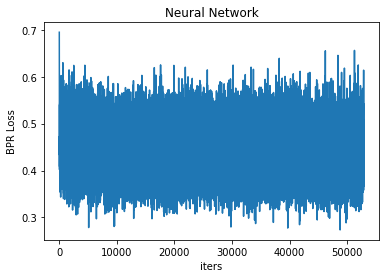

In [41]:
plt.title('Neural Network')
plt.xlabel('iters')
plt.ylabel('BPR Loss')
plt.plot(BPR_loss_hist)

In [42]:
epochs = 10
print_every = 5

In [43]:
#BPR_optimizer = optim.SGD(BPR_model.parameters(), lr=0.001)

for epoch in range(epochs):
        for batch_ind, (session_train, item_train, mask_train, y_train) in enumerate(BPR_train_loader):
            session_train, item_train, mask_train, y_train = session_train.cuda(), item_train.to(device), mask_train.to(device), y_train.to(device)

            pred_train = BPR_model(session_train, item_train)

            loss = BPRloss(pred_train, pred_train[torch.arange(pred_train.shape[0]), y_train.long()], mask_train)
            BPR_loss_hist.append(loss.data)

            BPR_optimizer.zero_grad()
            loss.backward()
            BPR_optimizer.step()

            if batch_ind % print_every == 0:
                train_log = 'Epoch {:2d}/{:2d}\tLoss: {:.7f}\tProgress: [{}/{} ({:.0f}%)]      '.format(
                    epoch+6, epochs+5, loss.cpu().item(), batch_ind+1, len(BPR_train_loader), 100. * batch_ind / len(BPR_train_loader))
                print(train_log, end='\r')
                sys.stdout.flush()

In [44]:
torch.save(BPR_model, 'CNN-e15-BPR-2')

/home/carrot_go_round/anaconda3/envs/ml/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


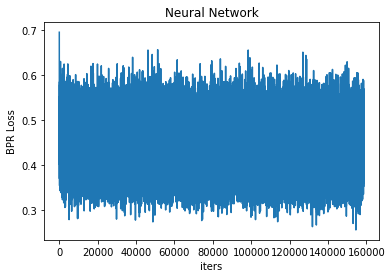

In [45]:
plt.title('Neural Network')
plt.xlabel('iters')
plt.ylabel('BPR Loss')
plt.plot(BPR_loss_hist)

# Inference and Submission Data Generation

In [19]:
x_test = []
choices_test = []
prices_test = []
metadata_test = []

with open('../Dataset/test.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)

    sess = []
    during_session = True

    for line in tqdm(reader):
        if during_session and line[4] in ['clickout item', 'interaction item rating', 'interaction item info', 'interaction item image', 'interaction item deals', 'search for item']:
            sess.append(line)
        elif not during_session and line[3]=='1':
            sess.append(line)
            during_session = True
        if line[4]=='clickout item' and line[5]=='':
            during_session = False
            x_test.append(embed_session(np.array(sess)))
            choices_test.append(np.asarray(list(map(int, sess[-1][10].split('|')))))
            prices_test.append(np.asarray(list(map(int, sess[-1][11].split('|')))))
            metadata_test.append(line[0:4] + [line[10]])
            sess = []

In [20]:
M = -1
m = 26
mask_test = []
for i in range(len(choices_test)):
    mask_test.append(len(choices_test[i]))
    if M < mask_test[-1]:
        M = mask_test[-1]
    if m >  mask_test[-1]:
        m =  mask_test[-1]
print(f"min: {m}, max: {M}")
print(f"len(mask): {len(mask_test)}")

min: 1, max: 25
len(mask): 253573


In [21]:
item_test = []
for i in tqdm(range(len(choices_test))):
    choice_items = []
    for j in range(len(choices_test[i])):
        choice_items.append(np.append(item_to_property[choices_test[i][j]], prices_test[i][j]))
    
    # for sessions with less than 25 impressions, the item vector is padded with zeros.
    for j in range(25-len(choices_test[i])):
        choice_items.append(np.zeros(158))
    tmp = np.asarray(choice_items, dtype=np.double)
    
    item_test.append(tmp)

In [23]:
BPR_model = torch.load('CNN-e15-BPR-2').to(device)

In [24]:
def pad_and_pack_test(batch):   # batch: a list of tuples of composition (sessions, items, masks, y)
    sessions = [item[0] for item in batch]
    lengths = [sess.shape[0] for sess in sessions]
    padded_sessions = nn.utils.rnn.pad_sequence(sessions, batch_first=True)
    packed_sessions = nn.utils.rnn.pack_padded_sequence(padded_sessions, lengths, batch_first=True, enforce_sorted=False)
    
    return (packed_sessions, 
                 torch.Tensor([item[1] for item in batch]), 
                 torch.LongTensor([item[2] for item in batch]), 
                 [item[3] for item in batch])

In [26]:
test_loader = torch.utils.data.DataLoader(RecSys2019('test'), shuffle=False, batch_size=1, collate_fn=pad_and_pack_test)

BPR_model.eval()

with open('CNN-BPR-e15-submission-2.csv', 'w') as w:
    writer = csv.writer(w)
    writer.writerow(['user_id', 'session_id', 'timestamp', 'step', 'item_recommendations'])
    
    for data_ind, (session_data, item_data, mask_data, metadata) in enumerate(test_loader):
        session_data, item_data, mask_data = session_data.cuda(), item_data.to(device), mask_data.to(device)
        
        prediction = BPR_model(session_data, item_data)
        
        pred_list = [p.item() for p in prediction[0]]
        choices = metadata[0][4].split('|')

        writer.writerow(metadata[0][0:4]+[' '.join(sorted(choices, reverse=True, key=lambda item : pred_list[choices.index(item)]))])
        
        if data_ind % 20 == 0:
            test_log = f'Progress: [{data_ind+1:06d}/{len(test_loader)} ({100.*data_ind/len(test_loader):.0f}%)]         '
            print(test_log, end='\r')
            sys.stdout.flush()